In [1]:
%matplotlib inline
from tqdm import tqdm
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = [20, 15]

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
from math import radians, cos, sin, asin, sqrt
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score

import json


In [2]:
train = pd.read_csv('features_train.csv')
test = pd.read_csv('features_test.csv')

In [55]:
train.head(3)

,id,vendor_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pick_month,hour,day_of_month,...,distance_manhattan,direction,pickup_cluster,dropoff_cluster,avg_speed_h_hour_pickup_cluster,cnt_hour_pickup_cluster,avg_speed_h_hour_dropoff_cluster,cnt_hour_dropoff_cluster,avg_speed_h_pickup_cluster_dropoff_cluster,cnt_pickup_cluster_dropoff_cluster
0,id2875421,2,-73.982155,40.767937,-73.964630,40.765602,455,3,17,14,...,1.735433,N,45,98,3.102208,1447.0,3.159945,1538.0,3.061823,685.0
1,id2377394,1,-73.980415,40.738564,-73.999481,40.731152,663,6,0,12,...,2.430506,SW,38,14,4.718804,418.0,3.787891,1413.0,2.828348,425.0
2,id3858529,2,-73.979027,40.763939,-74.005333,40.710087,2124,1,11,19,...,8.203575,W,17,86,3.044941,1152.0,3.890098,832.0,4.408868,132.0


In [56]:
test.head(3)

,id,vendor_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pick_month,hour,day_of_month,day_of_week,...,distance_manhattan,direction,pickup_cluster,dropoff_cluster,avg_speed_h_hour_pickup_cluster,cnt_hour_pickup_cluster,avg_speed_h_hour_dropoff_cluster,cnt_hour_dropoff_cluster,avg_speed_h_pickup_cluster_dropoff_cluster,cnt_pickup_cluster_dropoff_cluster
0,id3004672,1,-73.988129,40.732029,-73.990173,40.756680,3,17,14,0,...,2.913304,E,83,5,2.996854,857.0,2.573926,1828.0,3.394994,278.0
1,id3505355,1,-73.964203,40.679993,-73.959808,40.655403,6,0,12,6,...,3.104805,W,87,58,4.687110,209.0,6.020508,522.0,4.638582,119.0
2,id1217141,1,-73.997437,40.737583,-73.986160,40.729523,1,11,19,1,...,1.846340,NW,48,40,2.796624,1109.0,3.438260,622.0,2.949582,608.0


In [3]:
do_not_use_for_training = ['id','trip_duration']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

In [4]:
print(len(feature_names)) 
feature_names

20


['vendor_id',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pick_month',
 'hour',
 'day_of_month',
 'day_of_week',
 'distance_haversine',
 'distance_manhattan',
 'direction',
 'pickup_cluster',
 'dropoff_cluster',
 'avg_speed_h_hour_pickup_cluster',
 'cnt_hour_pickup_cluster',
 'avg_speed_h_hour_dropoff_cluster',
 'cnt_hour_dropoff_cluster',
 'avg_speed_h_pickup_cluster_dropoff_cluster',
 'cnt_pickup_cluster_dropoff_cluster']

In [5]:
y = np.log(train['trip_duration'].values + 1)

In [6]:
dtrain = train[feature_names]
dtest = test[feature_names]

In [46]:
print(dtest.shape)
print(test.shape)

(625111, 20)
(625111, 21)


In [7]:
dtrain.isnull().sum()

vendor_id                                          0
pickup_longitude                                   0
pickup_latitude                                    0
dropoff_longitude                                  0
dropoff_latitude                                   0
pick_month                                         0
hour                                               0
day_of_month                                       0
day_of_week                                        0
distance_haversine                                 0
distance_manhattan                                 0
direction                                          0
pickup_cluster                                     0
dropoff_cluster                                    0
avg_speed_h_hour_pickup_cluster                23385
cnt_hour_pickup_cluster                        23385
avg_speed_h_hour_dropoff_cluster               20562
cnt_hour_dropoff_cluster                       20562
avg_speed_h_pickup_cluster_dropoff_cluster    

In [8]:
num_cols = list(dtrain.select_dtypes(exclude='object').columns)
cat_cols = list(dtrain.select_dtypes(include='object').columns)

In [57]:
cat_cols

['direction']

In [11]:
model_linear = LinearRegression()

# giving all values to pipeline
linear_pipe = Pipeline(steps=[('preprocessor', preprocessor),('linear', model_linear)])
linear_pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = linear_pipe.predict(X_val)

In [12]:
#Preprocessing for missing numerical data
num_transformer = Pipeline(steps = [
         ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
         ("norm", StandardScaler())])

# Preprocessing for categorical data
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_cols),
                    ('cat', cat_transformer, cat_cols)])
X_train, X_val, y_train, y_val = train_test_split(dtrain, y, test_size=0.2, random_state=1987)

In [13]:
print(linear_pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('norm',
                                                                   StandardScaler())]),
                                                  ['vendor_id',
                                                   'pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude',
                                                   'pick_month', 'hour',
                                                 

In [14]:
 #to print the results in good way
print(f"Validation RMSLE: {mean_squared_error(y_pred, y_val, squared=False)}")

Validation RMSLE: 0.5241187237408721


In [42]:
y_pre_linear = linear_pipe.predict(dtest)
#y_pre_linear = np.exp(y_pre_linear) - 1
y_pre_linear

array([6.73217773, 6.46098328, 6.16822815, ..., 7.17189026, 8.43513489,
       7.00042725])

In [47]:
len(y_pre_linear)

625111

In [16]:
new_df = test.copy()
new_df['trip_duration'] = y_pre_linear
new_df = new_df[['id', 'trip_duration']]
new_df.head()

,id,trip_duration
0,id3004672,837.972337
1,id3505355,638.689739
2,id1217141,476.339582
3,id2150126,980.756448
4,id1598245,536.720150


In [17]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=1000, min_samples_leaf=50, min_samples_split=75)

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),('rf', rf_model)])
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),('rf', rf_model)])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_val)

In [18]:
print(rf_pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('norm',
                                                                   StandardScaler())]),
                                                  ['vendor_id',
                                                   'pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude',
                                                   'pick_month', 'hour',
                                                 

In [20]:
y_pred_rf[:5]
#np.exp(y_pred_rf) - 1

array([7.60180476, 6.4816515 , 7.02000716, 5.59612819, 6.40912072])

In [50]:
len(y_pred_rf)

290939

In [51]:
y_pre_rf = rf_pipe.predict(dtest)
y_pre_rf = np.exp(y_pre_rf) - 1
y_pre_rf

array([ 900.62901857,  596.35383612,  516.88172575, ..., 1657.7009614 ,
       1731.44807011, 1418.70276835])

In [52]:
len(y_pre_rf)

625111

In [53]:
new_df_rf = test.copy()
new_df_rf['trip_duration'] = y_pre_rf
new_df_rf = new_df_rf[['id', 'trip_duration']]
new_df_rf.head()

,id,trip_duration
0,id3004672,900.629019
1,id3505355,596.353836
2,id1217141,516.881726
3,id2150126,931.043489
4,id1598245,346.431692


In [54]:
importances

array([2.54527042e-03, 3.90630668e-03, 3.95452033e-03, 5.41300542e-03,
       5.90564629e-03, 3.23200950e-03, 1.35178600e-02, 1.74815023e-03,
       1.55685401e-02, 8.04665709e-01, 7.40038927e-03, 1.06633496e-03,
       1.11860613e-03, 1.32459750e-02, 3.08835313e-03, 6.02092537e-02,
       2.69408250e-03, 4.45898226e-02, 1.86298398e-03, 1.55170724e-04,
       2.19220225e-04, 1.69548117e-03, 1.30571756e-04, 5.58484156e-04,
       2.86299651e-05, 1.35926910e-03, 1.20353829e-04])

In [64]:
from sklearn.compose import make_column_transformer

transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore", sparse=False), ['direction']),remainder='passthrough')

transformed = transformer.fit_transform(dtest)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())

In [65]:
transformed_df.head()

,onehotencoder__x0_E,onehotencoder__x0_N,onehotencoder__x0_NE,onehotencoder__x0_NW,onehotencoder__x0_S,onehotencoder__x0_SE,onehotencoder__x0_SW,onehotencoder__x0_W,vendor_id,pickup_longitude,...,distance_haversine,distance_manhattan,pickup_cluster,dropoff_cluster,avg_speed_h_hour_pickup_cluster,cnt_hour_pickup_cluster,avg_speed_h_hour_dropoff_cluster,cnt_hour_dropoff_cluster,avg_speed_h_pickup_cluster_dropoff_cluster,cnt_pickup_cluster_dropoff_cluster
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-73.988129,...,2.746426,2.913304,83.0,5.0,2.996854,857.0,2.573926,1828.0,3.394994,278.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-73.964203,...,2.759239,3.104805,87.0,58.0,4.687110,209.0,6.020508,522.0,4.638582,119.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-73.997437,...,1.306155,1.846340,48.0,40.0,2.796624,1109.0,3.438260,622.0,2.949582,608.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-73.956070,...,5.269088,7.163347,94.0,40.0,4.166311,926.0,3.358604,1934.0,6.510917,137.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-73.970215,...,0.960842,1.354164,27.0,80.0,3.375380,2316.0,3.117963,629.0,2.396920,673.0


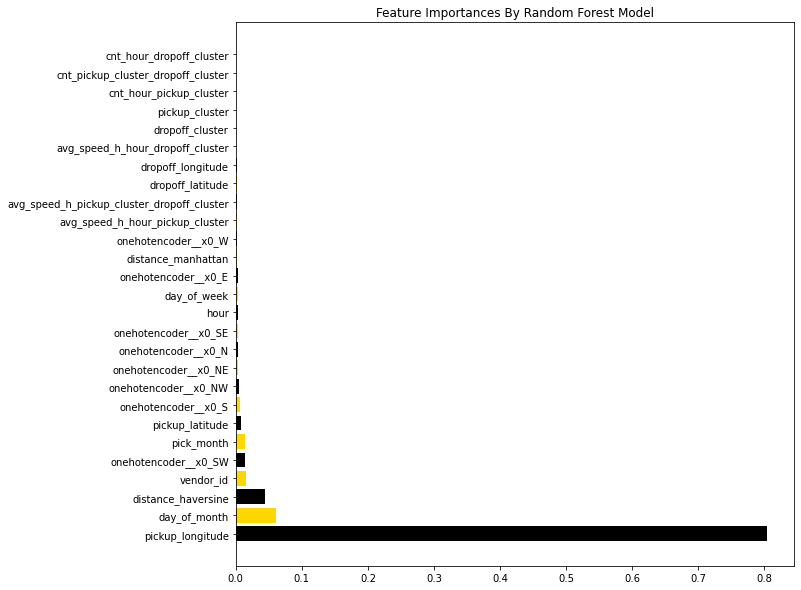

In [66]:
predictors = transformed_df.columns
importances=rf_model.feature_importances_
std = np.std([rf_model.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
plt.figure(figsize=(10,10))
plt.title("Feature Importances By Random Forest Model")
plt.barh(range(len(indices)), importances[indices],
       color=["black","gold"], yerr=std[indices], align="center")
plt.yticks(range(len(indices)), sorted_important_features, rotation='horizontal');

In [71]:
print(len(y_val))
print(len(y_pred_rf))

290939
290939


In [72]:
mse = mean_squared_error(y_val, y_pred_rf)
rmse = mse**.5
print(mse)
print(rmse)

0.12695507319273777
0.3563075542178944


In [ ]:
## Define Grid 
grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [18]
}
## show start time
print(datetime.now())
## Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid1, cv= 5)
CV_frf.fit(x_train, y_train)
## show end time
print(datetime.now())